# Analysis of ADCP velocity data

To extract:
    
    - Barotropic tidal currents
        - Defined as harmonically reconstructed depth-average currents
    - Low-frequency velocity
    -...

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from mycurrents import oceanmooring as om
import soda.dataio as io
from soda.utils.otherplot import polar_pdf, axcolorbar

from netCDF4 import Dataset
from datetime import datetime

from matplotlib import rcParams

%matplotlib inline

# Set font sizes (must be after %matplotlib inline)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "14"
rcParams['axes.labelsize']='large'



In [2]:
####
adcpfile = '../processed_data/RowleyShoals2019_RDI_QAQC.nc'

Tfile = '../processed_data/RowleyShoals_Gridded_Mooring_T_20sec_QC.nc'

#dbfile = '../KISSME2017_Obs.db'


site = 'T330'

if site=='WP':
    group1 = 'WP250_RDI_150_kHz_Quartermaster_11795'
    group2 = 'WP250_RDI_300_kHz_Sentinel_20092'
    Tgroup = 'WP250'
elif site=='SP':
    group1 = 'SP250_RDI75_kHz_Longranger_24613'
    group2 = None
    Tgroup = 'SP250'
elif site=='NP':
    group1 = 'NP250_RDI_150_kHz_Quartermaster_16856'
    group2 = 'NP250_RDI_300_kHz_Monitor_20089'
    Tgroup = 'NP250'

elif site=='T330':
    group1 = 'T330_RDI_75kHz_LR_16870'
    group2 = None
    Tgroup = 'T330'
    
t1 = datetime(2019,3,6,12,0,0,0)
t2 = datetime(2019,4,22,0,0,0,0)

#t1 = datetime(2017,4,2,12,0,0,0)
#t2 = datetime(2017,4,4,12,0,0,0)

cons = ['M2', 'S2','N2','K2','K1','O1','P1','Q1','M4','MS4','MN4','MM','MF','M6','M8']
#cons = ['M2', 'S2','N2','K2','K1','O1','P1','Q1']#,'M4','MS4','MN4','MM','MF','M6','M8']
#cons = ['M2', 'S2','K1','O1']

In [4]:
#####
# List the groups in the file
#nc = Dataset(adcpfile)
#for gg in nc.groups.keys():
#    print gg
#nc.close()

# Load the moorings
u = om.from_netcdf(adcpfile, 'u', group=group1)
v = om.from_netcdf(adcpfile, 'v', group=group1)
w = om.from_netcdf(adcpfile, 'w', group=group1)
if group2 is not None:
    u2 = om.from_netcdf(adcpfile, uvar, group=group2)
T = om.from_netcdf(Tfile, 'Temperature', group=Tgroup)

In [5]:
# Clip the time series
u = u.clip(t1,t2)
v = v.clip(t1,t2)
w = w.clip(t1,t2)

In [38]:
u.Z

array([ 10.98,  12.98,  14.98,  16.98,  18.98,  20.98,  22.98,  24.98,
        26.98,  28.98,  30.98,  32.98,  34.98,  36.98,  38.98,  40.98,
        42.98,  44.98,  46.98,  48.98,  50.98,  52.98,  54.98,  56.98,
        58.98,  60.98,  62.98,  64.98,  66.98,  68.98,  70.98,  72.98,
        74.98,  76.98,  78.98,  80.98,  82.98,  84.98,  86.98,  88.98,
        90.98,  92.98,  94.98,  96.98,  98.98, 100.98, 102.98, 104.98,
       106.98, 108.98, 110.98, 112.98, 114.98, 116.98, 118.98, 120.98,
       122.98, 124.98, 126.98, 128.98, 130.98, 132.98, 134.98, 136.98,
       138.98, 140.98, 142.98, 144.98, 146.98, 148.98, 150.98, 152.98,
       154.98, 156.98, 158.98, 160.98, 162.98, 164.98, 166.98, 168.98,
       170.98, 172.98, 174.98, 176.98, 178.98, 180.98, 182.98, 184.98,
       186.98, 188.98, 190.98, 192.98, 194.98, 196.98, 198.98, 200.98,
       202.98, 204.98, 206.98, 208.98, 210.98, 212.98, 214.98, 216.98,
       218.98, 220.98, 222.98, 224.98, 226.98, 228.98, 230.98, 232.98,
      

(-1, 1)

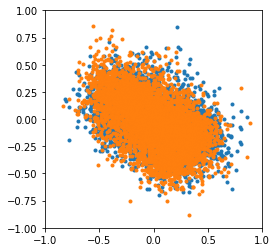

In [21]:
plt.figure()
plt.plot(u.y[20,:],v.y[2,:],'.')
plt.plot(u.y[20,:],v.y[10,:],'.')

plt.gca().set_aspect('equal')
plt.ylim(-1,1)
plt.xlim(-1,1)

In [6]:
u_low = u.godinfilt()
v_low = v.godinfilt()


Warning -- downsampling data to use Godin filter...


/home/suntans/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: invalid value encountered in true_divide
  ytmp2/=norm


Warning -- downsampling data to use Godin filter...


# Test a gap filling routine

In [10]:
ufill2 = u.fill_gaps_z(kind='nearest')


In [31]:
# Fill the gaps using chebyshev polynomials

#upd = pd.DataFrame(u.y.T, index=u.t,columns=u.Z)
#ufill = upd.interpolate(method='linear', axis=1)
y = u.y
yout = np.zeros(y.shape)
z = u.Z

order = 8
for ii in range(u.y.shape[1]):
    idx = y.mask[:,ii]
    coefs = np.polynomial.chebyshev.chebfit(z[~idx], y[~idx,ii], order)
    yout[idx,ii] = np.polynomial.chebyshev.chebval(z[idx],coefs)
    
    
    #F = interp1d(z[~idx], y[~idx,ii], kind='nearest', bounds_error=False, fill_value='extrapolate')
    #yout[idx,ii] = F(z[idx])
    yout[~idx,ii] = y[~idx,ii]
    


Text(0.5, 1.0, 'u [m/s]')

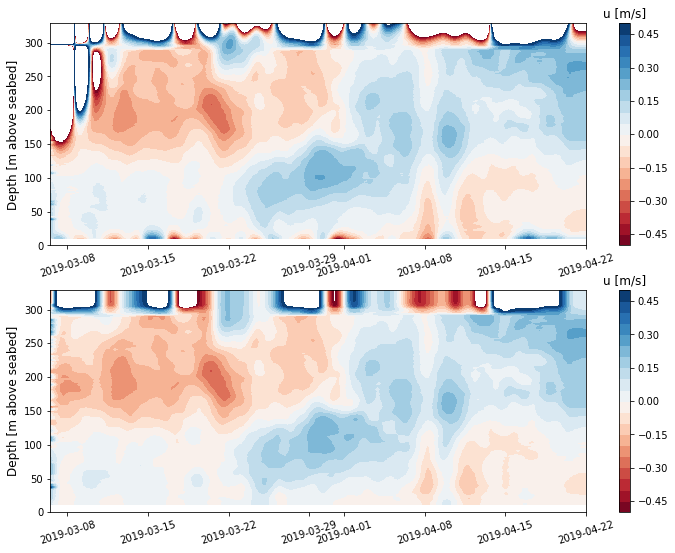

In [32]:
ufill = om.OceanMooring(u.t, yout, u.Z)

ulow = om.OceanMooring(u.t, ufill.filt(30*3600., btype='low'), u.Z)
ulow2 = om.OceanMooring(u.t, ufill2.filt(30*3600., btype='low'), u.Z)


plt.figure(figsize=(12,9))
ax=plt.subplot(211)
C,cb = ulow.contourf(np.arange(-0.5,0.55,0.05), cmap='RdBu')
cb.ax.set_title('u [m/s]')

ax=plt.subplot(212)
C,cb = ulow2.contourf(np.arange(-0.5,0.55,0.05), cmap='RdBu')
cb.ax.set_title('u [m/s]')

# Depth-average the velocity

Find the barotropic tide

In [22]:
ubar = om.OceanMooring(u.t, u.depthavg(), 0.)
vbar = om.OceanMooring(v.t, v.depthavg(), 0.)

#ubar = om.OceanMooring(Uobs.t, Uobs.depthavg(ztop=0, zbed=252), 0.)
#vbar = om.OceanMooring(Vobs.t, Vobs.depthavg(ztop=0, zbed=252), 0.)

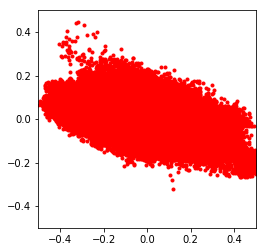

In [30]:
plt.plot(ubar.y,vbar.y,'r.')
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.gca().set_aspect('equal')


In [23]:
# Try filtering
ubarfilt = om.OceanMooring(ubar.t, ubar.filt([34*3600.,3.*3600.], btype='band', order=3), 0.)
vbarfilt = om.OceanMooring(vbar.t, vbar.filt([34*3600.,3.*3600.], btype='band', order=3), 0.)

ulowfilt = om.OceanMooring(ubar.t, ubar.filt(34*3600., btype='low', order=3), 0.)
ugodinfilt = ubar.godinfilt()
#ubarfilt.plot()
#plt.title('Band-passed filtered ubar')


Warning -- downsampling data to use Godin filter...


Text(0.5, 1.0, 'Band-passed filtered and raw ubar')

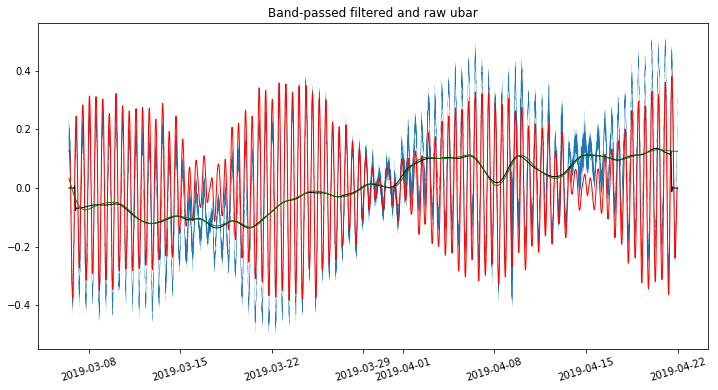

In [24]:
plt.figure(figsize=(12,6))
#plt.plot(Uobs.t, Uobs.y[-1,:], lw=0.25)
ubar.plot(lw=0.1)
ubarfilt.plot(color='r', lw=1)
ugodinfilt.plot(color='k', lw=1)
ulowfilt.plot(color='g', lw=1)
plt.title('Band-passed filtered and raw ubar')

# Harmonic fit the barotropic velocity

In [10]:
### Harmonic

uamp_obs, uphs_obs, f, umean_obs, ufit_obs, urms = ubar.tidefit(frqnames=cons, basetime=t1)
uamp_obs, uphs_obs, f, umean_obs, vfit_obs, vrms = vbar.tidefit(frqnames=cons, basetime=t1)
# Convert the reconstructed signals to oceanmooring objects

Ubar_fit = om.OceanMooring(ubar.t, ufit_obs, ubar.Z)
Vbar_fit = om.OceanMooring(vbar.t, vfit_obs, vbar.Z)
print 'Error = %f, %f'%(urms, vrms)

Error = 0.047946, 0.052795


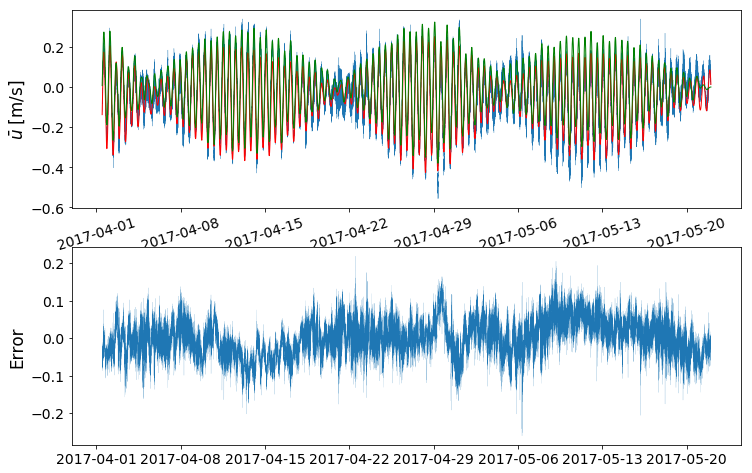

In [11]:
plt.figure(figsize=(12,8))
plt.subplot(211)
ubar.plot(lw=0.25)
Ubar_fit.plot(color='r', lw=1)
ubarfilt.plot(color='g', lw=1)
plt.ylabel(r'$\bar{u}$ [m/s]')

plt.subplot(212)
plt.plot(ubar.t, Ubar_fit.y-ubar.y, lw=.1)
plt.ylabel('Error')
#plt.xlim(datetime(2017,4,25),datetime(2017,4,25,12,0,0))

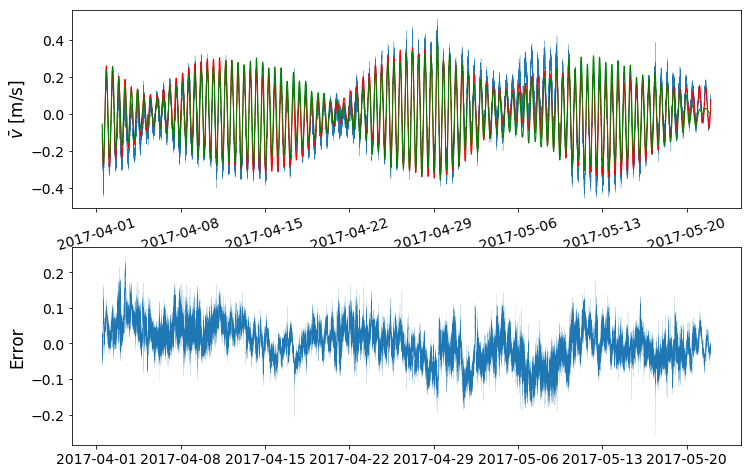

In [12]:
plt.figure(figsize=(12,8))
plt.subplot(211)
vbar.plot(lw=0.25)
Vbar_fit.plot(color='r', lw=1)
vbarfilt.plot(color='g', lw=1)
plt.ylabel(r'$\bar{v}$ [m/s]')

plt.subplot(212)
plt.plot(vbar.t, Vbar_fit.y-vbar.y, lw=.1)
plt.ylabel('Error')
#plt.xlim(datetime(2017,4,25),datetime(2017,4,25,12,0,0))

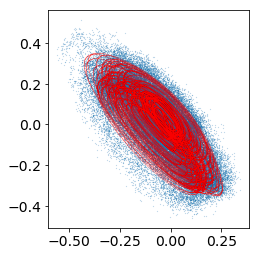

In [13]:
ax=plt.gca()
plt.plot(ubar.y, vbar.y,'.',ms=0.2)
plt.plot(Ubar_fit.y, Vbar_fit.y,'r.',ms=0.1)

ax.set_aspect('equal')


# Calculate the baroclinic velocity

Definition
$$
u'(z,t) = u(z,t) - \bar{u}_{tide}(t)
$$

where $\bar{u}_{tide}(t)$ is the tidal-fit to the depth-average. The baroclinic velocity will therefore contain all low and high-frequency info

In [14]:
u_bc = u.copy_like(u.t, u.y - ubar.y)
v_bc = v.copy_like(v.t, v.y - vbar.y)

plt.figure(figsize=(12,9))
ax=plt.subplot(211)
u_bc.contourf(np.arange(-0.8,0.9,0.1), cmap='RdBu')
#ax.set_ylim(250,0)

ax=plt.subplot(212)
v_bc.contourf(np.arange(-0.8,0.9,0.1), cmap='RdBu')
#ax.set_ylim(250,0)

In [15]:
# Godin filter the baroclinic
u_bc_low = u_bc.godinfilt()
v_bc_low = v_bc.godinfilt()

Warning -- downsampling data to use Godin filter...
Warning -- downsampling data to use Godin filter...


In [16]:
plt.figure(figsize=(12,9))
ax=plt.subplot(211)
u_bc_low.contourf(np.arange(-0.5,0.55,0.05), cmap='RdBu')
#ax.set_ylim(250,0)

ax=plt.subplot(212)
v_bc_low.contourf(np.arange(-0.5,0.55,0.05), cmap='RdBu')
#ax.set_ylim(250,0)

(<matplotlib.contour.QuadContourSet at 0x7f1c3d8770d0>,
 <matplotlib.colorbar.Colorbar at 0x7f1c3ced1490>)

In [17]:
# Tidal fit the baroclinic velocity

uamp_obs, uphs_obs, f, umean_obs, ufit_obs, urms = u_bc.tidefit(frqnames=cons, basetime=t1)
uamp_obs, uphs_obs, f, umean_obs, vfit_obs, vrms = v_bc.tidefit(frqnames=cons, basetime=t1)
# Convert the reconstructed signals to oceanmooring objects

Ubc_fit = om.OceanMooring(u_bc.t, ufit_obs, u_bc.Z, zvar=u_bc.zvar)
Vbc_fit = om.OceanMooring(v_bc.t, vfit_obs, v_bc.Z, zvar=v_bc.zvar)


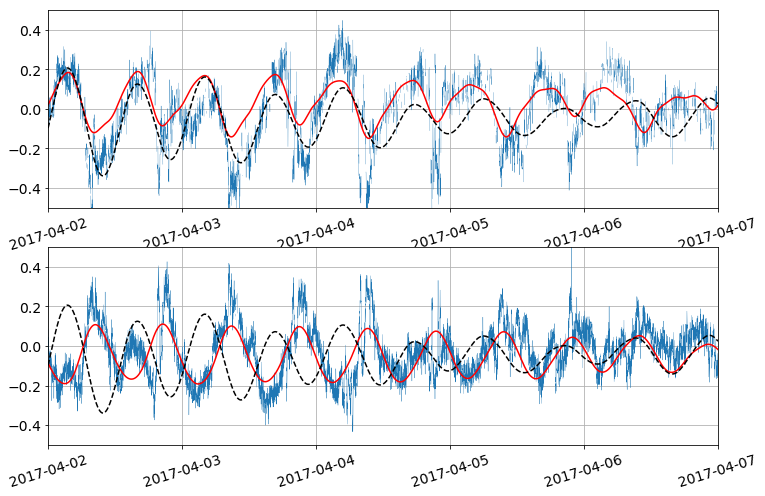

In [18]:
t1s = datetime(2017,4,2)
t2s = datetime(2017,4,7)
plt.figure(figsize=(12,8))

plt.subplot(211)

plt.plot(u_bc.t, u_bc.y[8,:],lw=0.3)
plt.plot(Ubc_fit.t, Ubc_fit.y[8,:],'r')
Ubar_fit.plot(color='k',ls='--')
plt.xlim(t1s,t2s)
plt.ylim(-0.5,0.5)
plt.grid(b=True)

plt.subplot(212)

plt.plot(u_bc.t, u_bc.y[48,:],lw=0.3)
plt.plot(Ubc_fit.t, Ubc_fit.y[48,:],'r')
Ubar_fit.plot(color='k',ls='--')
plt.xlim(t1s,t2s)
plt.ylim(-0.5,0.5)
plt.grid(b=True)



# Extract the pressure near the bed

In [19]:

# Load the field site
ssh = io.load_sql_ncstation(dbfile, 'SP250_SBE39_TP_6527',\
                'pressure')

# Clip and remove the mean
ssh = om.from_xray(ssh[0]).clip(t1,t2)
ssh.y = ssh.y-np.mean(ssh.y)

Querying database...
LOWER(Variable_Name) LIKE LOWER("pressure") and StationName LIKE "%SP250_SBE39_TP_6527%"
/home/suntans/Share/ARCHub/DATA/FIELD/browse-basin-kissme/Data/NetCDF/KISSME_SBE39Data.nc SP250_SBE39_TP_6527


In [20]:
plt.figure(figsize=(12,6))
ssh.plot(lw=0.25)
#plt.xlim(datetime(2017,4,29),datetime(2017,5,3))

In [21]:
uamp_obs, uphs_obs, f, umean_obs, ufit_obs, urms = ssh.tidefit(frqnames=cons, basetime=t1)

# Convert the reconstructed signals to oceanmooring objects
ufit_obs
ssh_fit = om.OceanMooring(ssh.t, ufit_obs, 0.)

print 'Error = %f'%urms

Error = 0.067858


In [22]:
plt.figure(figsize=(12,6))
ssh.plot(lw=0.25)
ssh_fit.plot(color='r', lw=0.25)

# Plot the velocity histograms at different levels


u.zvar

In [23]:
for ii, zz in enumerate(u.zvar.mean(axis=1)):
    print ii,zz

0 233.370324588
1 229.382760853
2 225.395197118
3 221.407633383
4 217.420069647
5 213.432505912
6 209.444942177
7 205.457378442
8 201.469814706
9 197.482250971
10 193.494687236
11 189.507123501
12 185.519559766
13 181.53199603
14 177.544432295
15 173.55686856
16 169.569304825
17 165.581741089
18 161.594177354
19 157.606613619
20 153.619049884
21 149.631486148
22 145.643922413
23 141.656358678
24 137.668794943
25 133.681231207
26 129.693667472
27 125.706103737
28 121.718540002
29 117.730976266
30 113.743412531
31 109.755848796
32 105.768285061
33 101.780721325
34 97.7931575901
35 93.8055938549
36 89.8180301196
37 85.8304663844
38 81.8429026491
39 77.8553389139
40 73.8677751786
41 69.8802114434
42 65.8926477081
43 61.9050839729
44 57.9175202376
45 53.9299565024
46 49.9423927671
47 45.9548290319
48 41.9672652967
49 37.9797015614
50 33.9921378262
51 30.0045740909
52 26.0170103557
53 22.0294466204
54 18.0418828852
55 14.0543191499
56 10.0667554147
57 6.07919167944
58 2.09162794419
59 -1.895

# Direction Histogram: Total Velocity

In [24]:
plt.figure(figsize=(12,6))

ax = plt.subplot(121, projection='polar')
C, ax1 =polar_pdf(u.y[8,:], v.y[8,:], ndirbins=90, ax=ax)
ax.set_title('Depth: 200 m')

ax = plt.subplot(122, projection='polar')
C, ax1 =polar_pdf(u.y[48,:], v.y[48,:], ndirbins=90, ax=ax)
ax.set_title('Depth: 40 m')

axcb = plt.axes([0.43,0.1, 0.16,0.05])
cb = plt.colorbar(C, cax=axcb, orientation='horizontal', format='%3.1f')
cb.ax.set_title('PDF [%]')

/home/suntans/anaconda/envs/suntans/lib/python2.7/site-packages/numpy/lib/function_base.py:973: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


# Directional Histogram: Low-frequency velocity

In [25]:
plt.figure(figsize=(12,6))
ax = plt.subplot(121, projection='polar')
C, ax1 =polar_pdf(u_low.y[8,:], v_low.y[8,:],ndirbins=31,nspeedbins=10,speedmax=0.5, ax=ax)
ax.set_title('Depth: 200 m')

ax = plt.subplot(122, projection='polar')
C, ax1 =polar_pdf(u_low.y[48,:], v_low.y[48,:], ndirbins=31,nspeedbins=10, speedmax=0.5, ax=ax)
ax.set_title('Depth: 40 m')

axcb = plt.axes([0.43,0.1, 0.16,0.05])
cb = plt.colorbar(C, cax=axcb, orientation='horizontal', format='%3.1f')
cb.ax.set_title('PDF [%]')

# Directional Histogram: Barotropic velocity

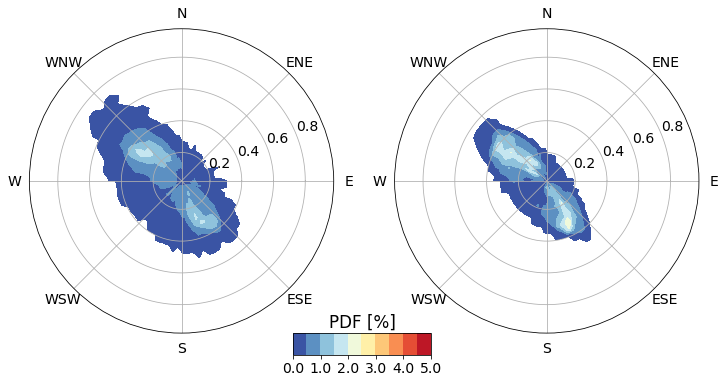

In [26]:
plt.figure(figsize=(12,6))
ax = plt.subplot(121, projection='polar')
C, ax1 =polar_pdf(ubar.y, vbar.y, ndirbins=90, ax=ax)

ax = plt.subplot(122, projection='polar')
C, ax1 =polar_pdf(Ubar_fit.y, Vbar_fit.y, ndirbins=90, ax=ax)

axcb = plt.axes([0.43,0.1, 0.16,0.05])
cb = plt.colorbar(C, cax=axcb, orientation='horizontal', format='%3.1f')
cb.ax.set_title('PDF [%]')

# Directional Histogram: Baroclinic velocity


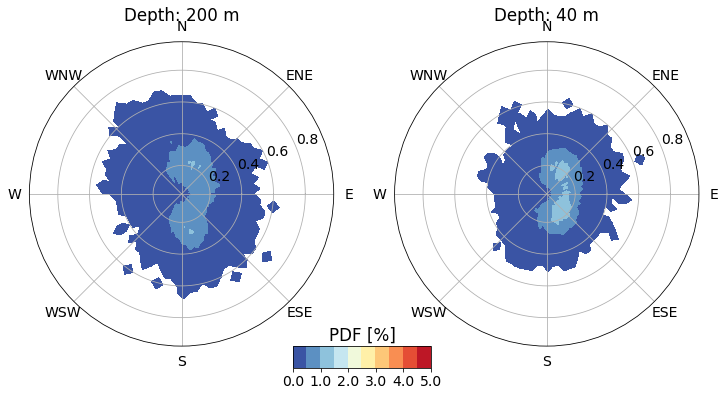

In [27]:
plt.figure(figsize=(12,6))

ax = plt.subplot(121, projection='polar')
C, ax1 =polar_pdf(u_bc.y[8,:]-u_low.y[8,:], v_bc.y[8,:]-v_low.y[8,:], ndirbins=90, ax=ax)
ax.set_title('Depth: 200 m')

ax = plt.subplot(122, projection='polar')
C, ax1 =polar_pdf(u_bc.y[48,:]-u_low.y[48,:], v_bc.y[48,:]-v_low.y[48,:], ndirbins=90, ax=ax)
ax.set_title('Depth: 40 m')

axcb = plt.axes([0.43,0.1, 0.16,0.05])
cb = plt.colorbar(C, cax=axcb, orientation='horizontal', format='%3.1f')
cb.ax.set_title('PDF [%]')